In [2]:
pip uninstall skater -y

Uninstalling skater-1.1.2b1:
  Successfully uninstalled skater-1.1.2b1
Note: you may need to restart the kernel to use updated packages.


In [1]:
# first we shall create a sample model 

from Models.fifa_model_generation import get_fifa_model

# the function returns a trained fifa model
model_obj, x_dataset, y_dataset  = get_fifa_model()
model_obj

/opt/conda/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
"""Interpretation Class"""

import pandas as pd

class DevExplainer:
    """
    Interpretation class. Before calling interpretation subclasses like partial
    dependence, one must call Interpretation.load_data().
    Examples
    --------
        >>> from skater.core.explanations import Interpretation
        >>> interpreter = Interpretation()
        >>> interpreter.load_data(X, feature_ids = ['a','b'])
        >>> interpreter.partial_dependence([feature_id1, feature_id2], regressor.predict)
    """

    def __init__(self, model_obj, x_train, y_train, model_type="classification", log_level=50, features=None, selective_features=None, target=None, unique_values = None, prediction_fn=None, sample=False):
        self.model = self.verify_model(model_obj)
        self.x_train = self.verify_data(x_train)
        self.y_train = self.verify_data(y_train)
        self.model_type = self.verify_model_type(model_type)
        self.feature_names = self.verify_features(features)
        self.target_names = self.verify_target(target)
        self.unique_values = self.verify_unqiue(unique_values)
        self.prediction_fn = prediction_fn
        self.log_level = log_level
        self.interpreter = None
        self.inmemory_model = None
        self.surrogate_explainer = None
        self.sampling = sample
        self.selective_features = self.verify_selective_features(selective_features)
        self.n_samples = x_dataset.shape[0] if self.sampling==False else 1000
        
    def verify_selective_features(self, selective_features):
        if selective_features is not None:
            print("\nSelective Features : ", selective_features)
            return selective_features
        else:
            return self.feature_names
    
    def verify_model(self, model):
        print("\nModel Object Type : ", type(model))
        if type(model) != "str":
            print("Model Object Validated")
        else:
            raise TypeError('Please provide Proper Model Object')
        return model
            
    def verify_data(self, dataset):
        print("\nValidating dataset")
        print("Dataset Type : ", type(dataset))
        if isinstance(dataset, pd.DataFrame) or isinstance(dataset, pd.Series):
            return dataset
        else:
            raise TypeError('Please provide dataset of type: \nPandas Dataframe\nPandas series')
    
    def verify_model_type(self, model_type):
        print("\nValidating model type")
        print("Type entered :", model_type.lower())
        if model_type.lower() == "classification" or model_type.lower() == "regression":
            print("Model Type Validated")
            return model_type.lower()
        else:
            raise TypeError('Please provide model_type: \nClassification \nRegression')
    
    def verify_features(self, features):
        if features is None:
            print("\nValidating feature names")
            print("List of features detected :", list(self.x_train))
            return list(self.x_train)

    def verify_target(self, target):
        if target is None:
            print("\nValidating target names")
            print("Target Column :", y_dataset.name)
            return [y_dataset.name]
            
    def verify_unqiue(self, unqiue):
        if unqiue is None:
            print("\nValidating Unique Values")
            if self.model_type == "classification":
                print("List of Target Values :", list(y_dataset.unique()))
                return list(y_dataset.unique())
            else:
                return None 
            
            
    def create_interpretation(self):
        from skater.core.explanations import Interpretation
        if self.interpreter is None:            
            print("Creating Interpretation")
            self.interpreter = Interpretation(
                training_data=self.x_train, 
                training_labels=self.y_train, 
                feature_names=self.feature_names,
                class_names=self.target_names,
                index=None,
                log_level=self.log_level
            )
            return self.interpreter
        else:
            return self.interpreter
        
        
    def create_inmemory_model(self):
        from skater.model import InMemoryModel
        print(self.inmemory_model)
        if self.inmemory_model is None:            
            print("Creating In Memory Model")
            self.inmemory_model = InMemoryModel(
                prediction_fn = self.model_prediction_fn(),
                input_formatter=None, 
                output_formatter=None, 
                target_names=self.target_names,
                feature_names=self.feature_names,
                unique_values=self.find_unique(),
                examples=self.x_train[0:10], 
                model_type="classifier" if self.model_type=="classification" else "regressor", 
                probability=True if self.model_type=="classification" else False, 
                log_level=self.log_level
            )
            return self.inmemory_model
        else:
            return self.inmemory_model

    def feature_importance_values(self):
        self.interpreter = self.create_interpretation()
        self.inmemory_model = self.create_inmemory_model()
        feature_importance = []
        feature_importance = self.interpreter.feature_importance.feature_importance(
                model_instance = self.inmemory_model, 
                ascending=False, 
                filter_classes=self.unique_values, 
                n_jobs=-1,
                progressbar=True, 
                n_samples=self.n_samples, 
                method='prediction-variance', 
                scorer_type='default',
                use_scaling=False
            )
        return feature_importance

    
    def feature_importance_plot(self):
        self.interpreter = self.create_interpretation()
        self.inmemory_model = self.create_inmemory_model()
        feature_importance = []
        feature_importance = self.interpreter.feature_importance.plot_feature_importance(
                ax=None, 
                n_features=1000, 
                importance_threshold=0.0, 
                figure_size=(50, 50),
                modelinstance = self.inmemory_model, 
                ascending=False, 
                filter_classes=self.unique_values, 
                n_jobs=-1,
                progressbar=True, 
                n_samples=self.n_samples, 
                method='prediction-variance', 
                scorer_type='default',
                use_scaling=False
            )
        return feature_importance

    
    def partial_dependence_values(self):
        self.interpreter = self.create_interpretation()
        self.inmemory_model = self.create_inmemory_model()
        pdp_list = []
        print(self.inmemory_model)
        for feature in self.selective_features:
            pdp = self.interpreter.partial_dependence.partial_dependence(
                feature_ids = [feature],
                modelinstance = self.inmemory_model, 
                filter_classes=self.unique_values, 
                grid=None,
                grid_resolution=1000, 
                n_jobs=-1, 
                grid_range=None, 
                sample=self.sampling,
                sampling_strategy='random-choice', 
                n_samples=self.n_samples,
                bin_count=50, 
                return_metadata=True,
                progressbar=True, 
            )
            pdp_list.append(pdp)
        return pdp_list

    def partial_dependence_plot(self):
        self.interpreter = self.create_interpretation()
        self.inmemory_model = self.create_inmemory_model()
        pdp_list = []
        print(self.selective_features)
        for feature in self.selective_features:
            pdp = self.interpreter.partial_dependence.plot_partial_dependence(
                [feature], 
                modelinstance = self.inmemory_model, 
                filter_classes=self.unique_values,
                grid=None, 
                grid_resolution=30, 
                grid_range=None,
                n_jobs=-1, 
                sample=False, 
                sampling_strategy='random-choice',
                n_samples=self.n_samples, 
                bin_count=50, 
                with_variance=False,
                figsize=(50, 50), 
                progressbar=True, 
                variance_type='estimate', 
                plot_title="Hello!!"
            )
            pdp_list.append(pdp)
        return pdp_list
    
    def verify_surrogate_explainer(self):
        if self.surrogate_explainer is None:
            self.interpreter = self.create_interpretation()
            self.inmemory_model = self.create_inmemory_model()
            surrogate_explainer = self.interpreter.tree_surrogate(
                oracle=self.inmemory_model, 
                seed=5, 
                splitter='best',
                max_depth=None,
                min_samples_split=2,
                min_samples_leaf=1,
                min_weight_fraction_leaf=0.0,
                max_features=None,
                max_leaf_nodes=10,
                min_impurity_decrease=0.0, 
                min_impurity_split=None, 
                class_weight="balanced",
                presort=True, 
                impurity_threshold=0.01
            )
            surrogate_explainer.fit(
                X=self.x_train,
                Y=self.y_train,
                use_oracle=True,
                prune='post',
                cv=5,
                n_iter_search=10,
                scorer_type='default',
                n_jobs=1, 
                param_grid=None, 
                impurity_threshold=0.01, 
                verbose=False
            )
            return surrogate_explainer
        else:
            return surrogate_explainer
    
    def surrogate_tree_values(self):
        self.surrogate_explainer = self.verify_surrogate_explainer()
#         [target_names, np.unique(y_train)][target_names is None],
        surrogate_tree_values = self.tree_generator(
            clf = self.surrogate_explainer._TreeSurrogate__model,
            features = self.feature_names, 
            labels = self.unique_values if self.model_type=="classification" else self.target_names, 
            original_features = self.feature_names, 
            node_index=0, 
            side=0, 
            prev_index=0
        )
        return surrogate_tree_values
        
    def surrogate_tree_plot(self):
        self.surrogate_explainer = self.verify_surrogate_explainer()
        _ = tree.plot_tree(clf, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)

#         plot_global_decisions(colors=None, enable_node_id=True, random_state=0, file_name='interpretable_tree.png', show_img=False, fig_size=(20, 8))

    def tree_generator(
        self, clf, features, labels, original_features, node_index=0, side=0, prev_index=0
    ):
        node_sum = 0
        class_names=labels
        if node_sum <= 5000000:
            node = {}
            if clf.tree_.children_left[node_index] == -1:  # indicates leaf
                count_labels = zip(clf.tree_.value[node_index, 0], labels)
                node["pred"] = ", ".join(
                    ("{} of {}".format(int(count), label) for count, label in count_labels)
                )

                node["side"] = "left" if side == "l" else "right"
                feature = features[clf.tree_.feature[prev_index]]
                threshold = clf.tree_.threshold[prev_index]

                if node_index == 0:
                    node["name"] = "Root >"
                elif ("_-_" in feature) and (feature not in original_features):

                    node["name"] = (
                        "{} = {}".format(feature.split("_-_")[0], feature.split("_-_")[1])
                        if side == "r"
                        else "{} != {}".format(
                            feature.split("_-_")[0], feature.split("_-_")[1]
                        )
                    )
                    node["type"] = "categorical"
                else:
                    node["name"] = (
                        "{} > {}".format(feature, round(threshold, 2))
                        if side == "r"
                        else "{} <= {}".format(feature, round(threshold, 2))
                    )
                    node["type"] = "numerical"

                left_index = clf.tree_.children_left[node_index]
                right_index = clf.tree_.children_right[node_index]

                if (clf.tree_.n_classes[0] != 1 and clf.tree_.n_outputs == 1):
                    node["value"]  = str(class_names[np.argmax(clf.tree_.value[node_index, 0])])
                else:
                    node["value"] = sum(clf.tree_.value[node_index, 0])
            else:

                count_labels = zip(clf.tree_.value[node_index, 0], labels)
                node["pred"] = ", ".join(
                    ("{} of {}".format(int(count), label) for count, label in count_labels)
                )

                node["side"] = "left" if side == "l" else "right"
                feature = features[clf.tree_.feature[prev_index]]
                threshold = clf.tree_.threshold[prev_index]

                if node_index == 0:
                    node["name"] = "Root >"
                elif ("_-_" in feature) and (feature not in original_features):

                    node["name"] = (
                        "{} = {}".format(feature.split("_-_")[0], feature.split("_-_")[1])
                        if side == "r"
                        else "{} != {}".format(
                            feature.split("_-_")[0], feature.split("_-_")[1]
                        )
                    )
                    node["type"] = "categorical"
                else:
                    node["name"] = (
                        "{} > {}".format(feature, round(threshold, 2))
                        if side == "r"
                        else "{} <= {}".format(feature, round(threshold, 2))
                    )
                    node["type"] = "numerical"

                left_index = clf.tree_.children_left[node_index]
                right_index = clf.tree_.children_right[node_index]

                if (clf.tree_.n_classes[0] != 1 and clf.tree_.n_outputs == 1):
                    node["value"]  = str(class_names[np.argmax(clf.tree_.value[node_index, 0])])
                else:
                    node["value"] = sum(clf.tree_.value[node_index, 0])
                node_length = len(str(node))
                node_sum += node_length
                node["children"] = [
                    self.tree_generator(
                        clf,
                        features,
                        labels,
                        original_features,
                        right_index,
                        "r",
                        node_index,
                    ),
                    self.tree_generator(
                        clf,
                        features,
                        labels,
                        original_features,
                        left_index,
                        "l",
                        node_index,
                    ),
                ]
            return node
                
    def model_prediction_fn(self):
        if self.prediction_fn is None:
            if callable(getattr(self.model, "predict_proba", None)):
                print("Checking if predict proba exists :",callable(getattr(self.model, "predict_proba", None)))
                return self.model.predict_proba            
            elif callable(getattr(self.model, "predict", None)):
                print("Checking if predict exists :",callable(getattr(self.model, "predict", None)))
                return self.model.predict
            else:
                raise TypeError("Please pass appropriate prediction function")
        else:
            return self.prediction_fn
    
    def find_unique(self):
        if self.model_type == "classification":
            return list(self.y_train.unique())
        else:
            return None
    
            
    def wait(self, wait_time):
        import time
        time.sleep(wait_time)

In [20]:
explainer_obj = DevExplainer(
    model_obj = model_obj,
    x_train = x_dataset,
    y_train = y_dataset,
    model_type = "Regression",
    log_level = 50,
    sample = False,
    selective_features = ['age', 'height_cm', 'weight_kg']
)
abc = explainer_obj.verify_surrogate_explainer()
# explainer_obj.partial_dependence_plot()
# explainer_obj.partial_dependence_values()
# explainer_obj.feature_importance_values()
# explainer_obj.feature_importance_plot()
# explainer_obj.surrogate_tree_values()
# explainer_obj.surrogate_tree_plot()


2021-07-21 15:17:10,271 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2021-07-21 15:17:10,279 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used MAE
2021-07-21 15:17:10,279 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 2359885.5288450164
2021-07-21 15:17:10,288 - skater.core.global_interpretation.tree_surrogate - INFO - Summary: childrens of the following nodes are removed []
2021-07-21 15:17:10,289 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (3750,)
2021-07-21 15:17:10,290 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 2359885.529; oracle score 2212720.936



Model Object Type :  <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
Model Object Validated

Validating dataset
Dataset Type :  <class 'pandas.core.frame.DataFrame'>

Validating dataset
Dataset Type :  <class 'pandas.core.series.Series'>

Validating model type
Type entered : regression
Model Type Validated

Validating feature names
List of features detected : ['age', 'height_cm', 'weight_kg', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve']

Validating target names
Target Column : value_eur

Validating Unique Values

Selective Features :  ['age', 'height_cm', 'weight_kg']
Creating Interpretation
None
Creating In Memory Model
Checking if predict exists : True


[Text(789.2763157894736, 978.48, 'attacking_short_passing <= 80.5\nmse = 58135050667877.27\nsamples = 3750\nvalue = 7520185.333'),
 Text(477.2368421052631, 761.0400000000001, 'skill_dribbling <= 80.5\nmse = 19817528070318.297\nsamples = 3512\nvalue = 6261572.581'),
 Text(293.6842105263158, 543.6, 'attacking_heading_accuracy <= 78.5\nmse = 13666449664564.344\nsamples = 3315\nvalue = 5765706.816'),
 Text(146.8421052631579, 326.1600000000001, 'attacking_short_passing <= 74.5\nmse = 7712939085944.469\nsamples = 3080\nvalue = 5288906.063'),
 Text(73.42105263157895, 108.72000000000003, 'mse = 5522403662501.77\nsamples = 2440\nvalue = 4693359.819'),
 Text(220.26315789473682, 108.72000000000003, 'mse = 9556894368953.469\nsamples = 640\nvalue = 7559426.12'),
 Text(440.52631578947364, 326.1600000000001, 'attacking_short_passing <= 74.5\nmse = 49664181398324.59\nsamples = 235\nvalue = 12014840.079'),
 Text(367.10526315789474, 108.72000000000003, 'mse = 32329989391036.97\nsamples = 179\nvalue = 99

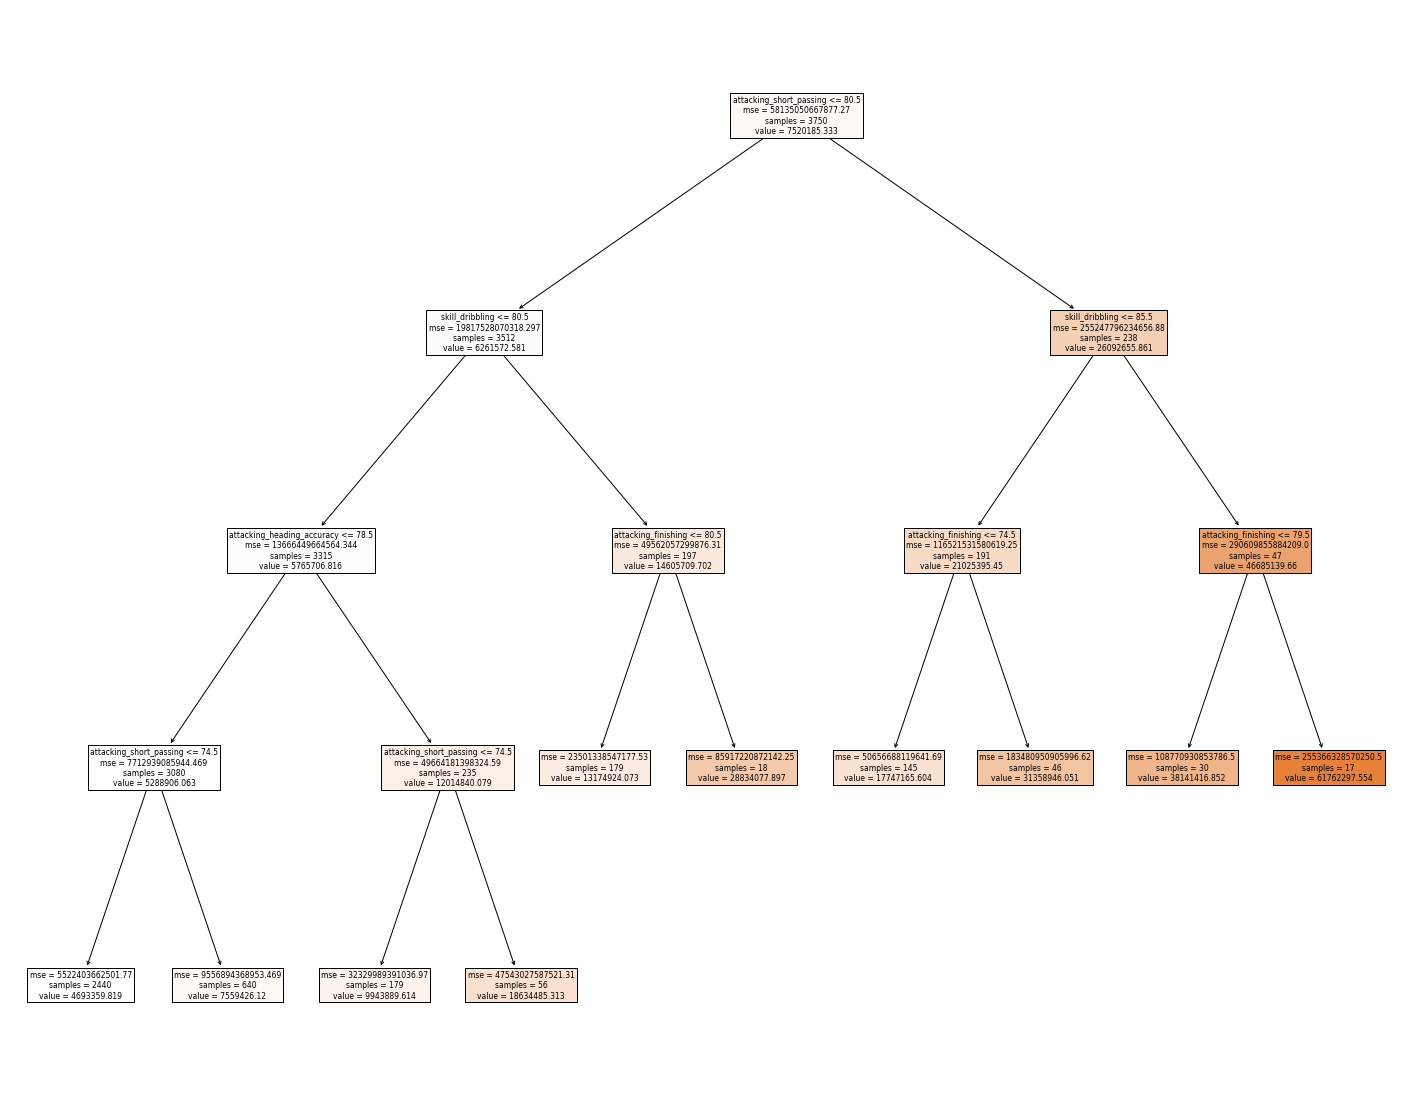

In [21]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
fig = plt.figure(figsize=(25,20))
asd = tree.plot_tree(abc.estimator_, 
               feature_names=list(x_dataset),  
               class_names=["value"],
               filled=True
              )
asd
# tree.export_text(abc.estimator_)

In [36]:
# abc.decisions_as_txt() # okay this is useful 
dir(abc)
# print("_post_pruning'", abc._post_pruning())
# print('_pre_pruning', abc._pre_pruning())
# print('best_score_', abc.best_score_)
print('class_names', abc.class_names)
print('criterion_types', abc.criterion_types)
# print('decisions_as_txt', abc.decisions_as_txt)
print('estimator_', abc.estimator_)
print('estimator_type_', abc.estimator_type_)
print('feature_names', abc.feature_names)
# print('fit', abc.fit)
print('impurity_threshold', abc.impurity_threshold)
# print('logger', abc.logger)
# print('oracle', abc.oracle)
print('plot_global_decisions', help(abc.plot_global_decisions))
# print('predict', abc.predict)
# print('scorer_name_', abc.scorer_name_)
# print('seed', abc.seed)
# print('splitter', abc.splitter)
# print('splitter_types', abc.splitter_types)

class_names ['value_eur']
criterion_types {'classifier': {'criterion': ['gini', 'entropy']}, 'regressor': {'criterion': ['mse', 'friedman_mse', 'mae']}}
estimator_ DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=100, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=True, random_state=5, splitter='best')
estimator_type_ regressor
feature_names ['age', 'height_cm', 'weight_kg', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve']
impurity_threshold 0.01
Help on method plot_global_decisions in module skater.core.global_interpretation.tree_surrogate:

plot_global_decisions(colors=None, enable_node_id=True, random_state=0, file_name='interpretable_tree.png', show_img=False, fig_siz

In [5]:
abc.estimator_

NameError: name 'abc' is not defined